<a href="https://colab.research.google.com/github/ChandrashekarCYoga/Face-mask-Segmentation/blob/master/Project_Computer_Vision_Face_Segmentation_Chandrashekar_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CV Project -Face Mask Segmentation
##Project Description:
In this hands-on project, the goal is to build a Face Mask Segmentation model
which includes building a face detector to locate the position of a face in an
image.
##Data Description:
####WIDER Face Dataset
WIDER FACE dataset is a Face Mask Segmentation benchmark dataset, of which
images are selected from the publicly available WIDER dataset.
This data have 32,203 images and 393,703 faces are labeled with a high degree of
variability in scale, pose and occlusion as depicted in the sample images.
In this project, we are using 409 images and around 1000 faces for ease of
computation.<br>
We will be using transfer learning on an already trained model to build our
segmenter. We will perform transfer learning on the MobileNet model which is
already trained to perform image segmentation. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face mask
segmentation. To be able to train the MobileNet model for face mask
segmentation, we will be using the WIDER FACE dataset for various images with a
single face and multiple faces. The output of the model is the face mask
segmented data which masks the face in an image. We learn to build a face mask
segmentation model using Keras supported by Tensorflow.
####Reference
Acknowledgment for the datasets.
http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/
Mobile Net paper: https://arxiv.org/pdf/1704.04861.pdf
##Objective:
In this problem, we use "Transfer Learning" of an Image Segmentation model to
detect any object according to the problem in hand.
Here, we are particularly interested in segmenting faces in a given image
###Steps and Tasks:
<ol>
  <li>Load the dataset given in form .npy format.</li>
-- We have already extracted the images from wider face-dataset and added it in the file images.npy. You can directly use this file for this project.<br>
-- “images.npy” contains details about the image and it’s masks, <br>
-- there is no separate CSV file for that
-- There is no separate train and test data given
<li> Create Features(images) and labels(mask) using that data.</li>
<li> Load the pre-trained model and weights.</li>
<li> Create a model using the above model.</li>
<li> Define the Dice Coefficient and Loss function.</li>
<li> Compile and fit the model.</li>
<li> Evaluate the model.</li>
</ol>

### 1. Load the dataset given in form .npy format.

Firstly, let's select TensorFlow version 2.x in colab


In [2]:
%tensorflow_version 2.x
import tensorflow 
tensorflow.__version__

'2.3.0'

In [3]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

###Load the dataset

As we are using google colab, we need to mount the google drive to load the data file

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Add path to the folder where your dataset files are

In [5]:
import numpy as np
from PIL import Image

images_path = '/content/drive/My Drive/GLProjects/FaceMaskSegmentation/Data/images.npy'

data = np.load(images_path, allow_pickle = True)


### Check one sample from the loaded "images.npy" file 

In [6]:
print (data[10][1])

data[10][1]

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

In [7]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

### 2. Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [8]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]),  28,28))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * 28)
        x2 = int(i["points"][1]['x'] * 28)
        y1 = int(i["points"][0]['y'] * 28)
        y2 = int(i["points"][1]['y'] * 28)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array

In [9]:
print("X_train_shape:", X_train.shape)
print("mask_shape:", masks.shape)

X_train_shape: (409, 224, 224, 3)
mask_shape: (409, 28, 28)


In [10]:
from sklearn.model_selection import train_test_split

# Split train and valid
X_train, X_valid, masks, y_valid = train_test_split(X_train, masks, test_size=0.02, random_state=1)

In [11]:
print("X_train_shape:", X_train.shape)
print("mask_shape:", masks.shape)
print("X_valid_shape:", X_valid.shape)
print("y_valid_shape:", y_valid.shape)

X_train_shape: (400, 224, 224, 3)
mask_shape: (400, 28, 28)
X_valid_shape: (9, 224, 224, 3)
y_valid_shape: (9, 28, 28)


### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.96862745  0.97647059  0.93725491]
  [ 0.94509804  0.88235295  0.79607844]
  [ 0.71764708  0.54509807  0.0196079 ]
  ...
  [ 1.          0.98431373  0.99215686]
  [ 0.98431373  0.98431373  0.98431373]
  [ 0.99215686  0.99215686  0.99215686]]

 [[ 0.99215686  0.96078432  0.96862745]
  [ 0.77254903  0.63137257  0.30196083]
  [ 0.81176472  0.67058825  0.27058828]
  ...
  [ 0.99215686  0.97647059  0.98431373]
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.98431373  0.98431373  0.98431373]]

 [[ 0.93725491  0.96078432  0.95294118]
  [ 0.56862748  0.41960788 -0.47450978]
  [ 0.9137255   0.73333335  0.36470592]
  ...
  [ 1.          0.98431373  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]]

 ...

 [[ 0.30196083  0.10588241 -0.64705884]
  [ 0.17647064  0.02745104 -0.92941177]
  [-0.24705881 -0.24705881 -0.96862745]
  ...
  [-0.34901959  0.65490198  0.45882356]
  [-0.39607841  0.60784316  0.45882356]
  [-0.33333331  0.62352943  0.47450984]]

 [

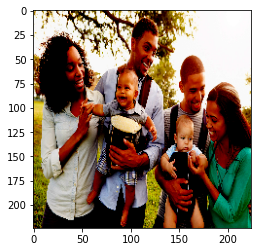

In [12]:
from matplotlib import pyplot
n = 21
print(X_train[n])
pyplot.imshow(X_train[n])

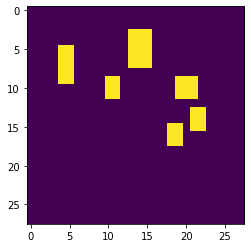

In [13]:
pyplot.imshow(masks[n])


## 3. Load the pre-trained model and weights.
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [14]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

## 4. Create a model using the above model.

In [15]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

- Create the model and print summary

In [16]:
model = create_model(False)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

## 5. Define the Dice Coefficient and Loss function.
- Define the Dice Cofficient

In [17]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

- Define the loss function

In [18]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

## 6. Compile and fit the model.
- Define optimizer
- Define metrics
- Define loss

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [20]:
EPOCHS = 100 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 1 # Depends on your GPU or CPU RAM.
PATIENCE = 5 # Patience for early stopping
VERBOSE = 1

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=PATIENCE, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [22]:
model.fit(X_train, masks, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = VERBOSE)



Epoch 1/100
400/400 [==============================] - 29s 72ms/step - loss: 2.1115 - dice_coefficient: 0.2638
Epoch 2/100
400/400 [==============================] - 29s 72ms/step - loss: 1.3051 - dice_coefficient: 0.4123
Epoch 3/100
400/400 [==============================] - 30s 75ms/step - loss: 1.1120 - dice_coefficient: 0.4740
Epoch 4/100
400/400 [==============================] - 31s 77ms/step - loss: 1.0216 - dice_coefficient: 0.5070
Epoch 5/100
400/400 [==============================] - 29s 72ms/step - loss: 0.9725 - dice_coefficient: 0.5275
Epoch 6/100
400/400 [==============================] - 29s 73ms/step - loss: 0.9388 - dice_coefficient: 0.5420
Epoch 7/100
400/400 [==============================] - 28s 71ms/step - loss: 0.9127 - dice_coefficient: 0.5530
Epoch 8/100
400/400 [==============================] - 29s 72ms/step - loss: 0.8919 - dice_coefficient: 0.5615
Epoch 9/100
400/400 [==============================] - 29s 72ms/step - loss: 0.8792 - dice_coefficient: 0.5685
E

- Save the Model

In [23]:
model.save('face_detection.h5')

## 7. Evaluate the model.

In [24]:
model.evaluate(X_valid,y_valid,batch_size=10)

1/1 [==============================] - 0s 2ms/step - loss: 0.7689 - dice_coefficient: 0.6219


[0.7688935399055481, 0.6219285130500793]

### Get the predicted mask for a sample image   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


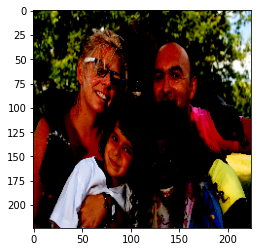

In [25]:
import matplotlib.pyplot as plt
THRESHOLD = 0.8
EPSILON = 0.02
n = 15

unscaled = X_train[n]

image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
            y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
            x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
            y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
            cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2, x:x2] = 1

contours, hierarchy = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.rectangle(unscaled, (x, y), (x + w, y + h), (0, 255, 0), 1)

plt.imshow(unscaled)

### Impose the mask on the image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


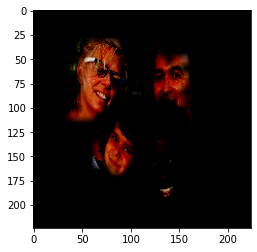

In [26]:
import matplotlib.pyplot as plt
n = 15
image = X_train[n]

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.3), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28)


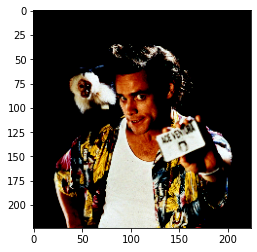

In [27]:
import matplotlib.pyplot as plt

n = 58

unscaled = X_train[n]

image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
print(region.shape)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
       
        if region[i][j] > THRESHOLD:
            x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
            y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
            x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
            y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
             #cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2, x:x2] = 1

contours, hierarchy = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.rectangle(unscaled, (x, y), (x + w, y + h), (0, 255, 0), 1)

plt.imshow(unscaled)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


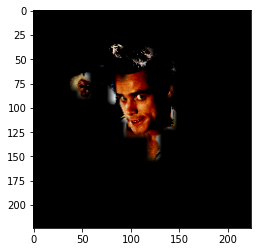

In [28]:
import matplotlib.pyplot as plt
n = 58
image = X_train[n]

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.3), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


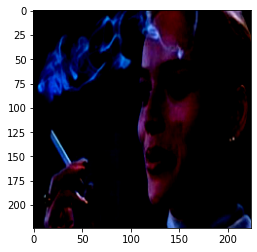

In [29]:

n = 121

unscaled = X_train[n]

image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
            y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
            x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
            y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
            cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2, x:x2] = 1

contours, hierarchy = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.rectangle(unscaled, (x, y), (x + w, y + h), (0, 255, 0), 1)

plt.imshow(unscaled)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


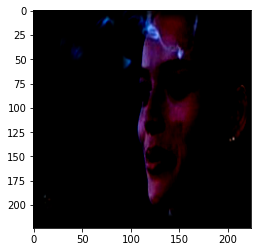

In [30]:
import matplotlib.pyplot as plt
n = 121
image = X_train[n]

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.3), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

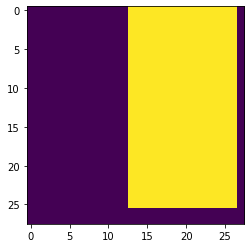

In [31]:

import matplotlib.pyplot as plt
n = 121
image = masks[n]
plt.imshow(image)
